In [284]:
from ppget.source import ModelSource

start_date = "2008-01-01"
end_date = "2008-07-01"
feature = "Global_active_power"

source = ModelSource.load(start_date, end_date, feature)
source.missing_data()

Series([], Freq: H, Name: Global_active_power, dtype: float64)

In [285]:
series = source.series()
series.head()

timestamp
2008-01-01 00:00:00    1.596933
2008-01-01 01:00:00    1.619567
2008-01-01 02:00:00    2.473733
2008-01-01 03:00:00    2.731133
2008-01-01 04:00:00    2.431133
Freq: H, Name: Global_active_power, dtype: float64

In [286]:
from ppget.datastructure import DatasetBuilder, TrainSplit

WINDOW = 32
MODEL_NAME = "model/cnn1D/"

builder = DatasetBuilder(series, data_split=TrainSplit(train=0.8, validation=0.1), window_size=WINDOW, normalised=False)

S = builder.build_splits()

S["training"]["X"].shape, S["training"]["y"].shape, S["validation"]["X"].shape, S["validation"]["y"].shape, S["test"]["X"].shape, S["test"]["y"].shape

((3468, 32, 1), (3468,), (433, 32, 1), (433,), (435, 32, 1), (435,))

In [287]:
from tensorflow.python.keras.metrics import RootMeanSquaredError
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.losses import MeanSquaredError
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, InputLayer, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.python.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(InputLayer((WINDOW, 1)))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Conv1D(32, kernel_size=2, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, 'relu'))
model.add(Dense(32, 'relu'))
model.add(Dense(1, 'linear'))
checkpoint = ModelCheckpoint(MODEL_NAME, save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 31, 64)            192       
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 30, 32)            4128      
_________________________________________________________________
dropout_50 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 15, 32)            0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 480)               0         
_________________________________________________________________
dense_138 (Dense)            (None, 256)               123136    
_________________________________________________________________
dense_139 (Dense)            (None, 32)              

In [288]:
%%time
history = model.fit(S["training"]["X"], S["training"]["y"],
                    epochs=100,
                    validation_data=(S["validation"]["X"], S["validation"]["y"]),
                    verbose=2,
                    callbacks=[checkpoint])

Epoch 1/100
109/109 - 1s - loss: 1.4862 - root_mean_squared_error: 1.2191 - val_loss: 0.5947 - val_root_mean_squared_error: 0.7712
INFO:tensorflow:Assets written to: model/cnn1D/assets
Epoch 2/100
109/109 - 1s - loss: 0.7532 - root_mean_squared_error: 0.8679 - val_loss: 0.5132 - val_root_mean_squared_error: 0.7164
INFO:tensorflow:Assets written to: model/cnn1D/assets
Epoch 3/100
109/109 - 1s - loss: 0.6581 - root_mean_squared_error: 0.8112 - val_loss: 0.4357 - val_root_mean_squared_error: 0.6601
INFO:tensorflow:Assets written to: model/cnn1D/assets
Epoch 4/100
109/109 - 1s - loss: 0.6000 - root_mean_squared_error: 0.7746 - val_loss: 0.4308 - val_root_mean_squared_error: 0.6564
INFO:tensorflow:Assets written to: model/cnn1D/assets
Epoch 5/100
109/109 - 0s - loss: 0.5543 - root_mean_squared_error: 0.7445 - val_loss: 0.4068 - val_root_mean_squared_error: 0.6378
INFO:tensorflow:Assets written to: model/cnn1D/assets
Epoch 6/100
109/109 - 0s - loss: 0.5309 - root_mean_squared_error: 0.7287 -

In [289]:
from tensorflow.python.keras.models import load_model

model = load_model(MODEL_NAME)

predictions = model.predict(S["test"]["X"]).flatten()
len(predictions)

435

In [290]:
import pandas as pd

test_results = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": S["test"]["y"]})
test_results

,Predictions,Ground Truth
0,1.802163,1.379500
1,1.134171,1.067300
2,0.809006,0.402267
3,0.513072,0.223900
4,0.236556,0.316600
...,...,...
430,0.510434,0.425367
431,0.586091,0.264067
432,0.676852,0.256433
433,0.773334,0.280500


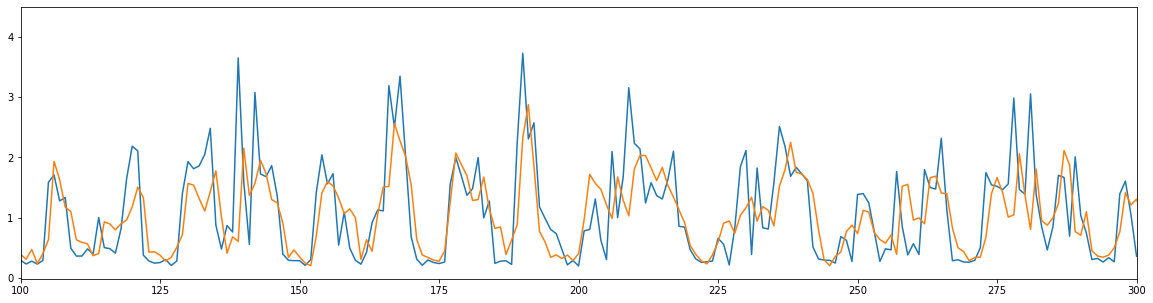

In [292]:
import matplotlib.pyplot as plt
import matplotlib as mplt
mplt.rcParams["figure.figsize"] = (20,5)

plt.xlim([100, 300])
plt.plot(test_results["Ground Truth"])
plt.plot(test_results["Predictions"])
plt.show()